In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-11-22 14:42:28.449481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_batch(file_path):
    """Load a single batch file from CIFAR-10 dataset."""
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict

In [5]:
def load_cifar10(data_path):
    """
    Load the complete CIFAR-10 dataset.
    
    Returns:
        (X_train, y_train), (X_test, y_test), label_names
    """
    train_data = []
    train_labels = []
    
    # Load training batches
    for i in range(1, 6):
        file_name = os.path.join(data_path, f'data_batch_{i}')
        batch = load_batch(file_name)
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']
        
    train_data = np.concatenate(train_data)
    train_labels = np.array(train_labels)
    
    # Load test batch
    test_batch = load_batch(os.path.join(data_path, 'test_batch'))
    test_data = test_batch[b'data']
    test_labels = np.array(test_batch[b'labels'])
    
    # Load label names
    meta_data = load_batch(os.path.join(data_path, 'batches.meta'))
    label_names = [label.decode('utf-8') for label in meta_data[b'label_names']]
    
    # Reshape data to (N, 32, 32, 3)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    return (train_data, train_labels), (test_data, test_labels), label_names

In [6]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Build a custom CNN model for image classification.
    
    Architecture:
    - 3 Convolutional blocks with BatchNorm and Dropout
    - MaxPooling after each block
    - Fully connected layers with Dropout
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [7]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix - Custom CNN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

TensorFlow version: 2.16.2
Loading CIFAR-10 dataset...
Training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Building CNN model...


/opt/miniconda3/envs/neural-networks/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

Training model...
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.3208 - loss: 2.1765
Epoch 1: val_accuracy improved from None to 0.55590, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 303ms/step - accuracy: 0.3995 - loss: 1.7800 - val_accuracy: 0.5559 - val_loss: 1.2282
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5341 - loss: 1.3079
Epoch 2: val_accuracy improved from 0.55590 to 0.61960, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 319ms/step - accuracy: 0.5535 - loss: 1.2457 - val_accuracy: 0.6196 - val_loss: 1.1163
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6142 - loss: 1.0903
Epoch 3: val_accuracy improved from 0.61960 to 0.62570, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 342ms/step - accuracy: 0.6197 - loss: 1.0732 - val_accuracy: 0.6257 - val_loss: 1.1544
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6491 - loss: 0.9929
Epoch 4: val_accuracy improved from 0.62570 to 0.65670, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 341ms/step - accuracy: 0.6569 - loss: 0.9715 - val_accuracy: 0.6567 - val_loss: 1.0186
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6823 - loss: 0.8995
Epoch 5: val_accuracy improved from 0.65670 to 0.66520, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 326ms/step - accuracy: 0.6871 - loss: 0.8902 - val_accuracy: 0.6652 - val_loss: 1.0571
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6996 - loss: 0.8558
Epoch 6: val_accuracy improved from 0.66520 to 0.73350, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 209s 334ms/step - accuracy: 0.7030 - loss: 0.8459 - val_accuracy: 0.7335 - val_loss: 0.7708
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7184 - loss: 0.8149
Epoch 7: val_accuracy improved from 0.73350 to 0.74900, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 339ms/step - accuracy: 0.7210 - loss: 0.8015 - val_accuracy: 0.7490 - val_loss: 0.7146
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7321 - loss: 0.7668
Epoch 8: val_accuracy did not improve from 0.74900
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.7352 - loss: 0.7609 - val_accuracy: 0.7267 - val_loss: 0.8053
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7495 - loss: 0.7227
Epoch 9: val_accuracy improved from 0.74900 to 0.76530, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.7474 - loss: 0.7309 - val_accuracy: 0.7653 - val_loss: 0.6787
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7613 - loss: 0.6976
Epoch 10: val_accuracy improved from 0.76530 to 0.79160, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2219s 4s/step - accuracy: 0.7615 - loss: 0.6953 - val_accuracy: 0.7916 - val_loss: 0.6064
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7660 - loss: 0.6758
Epoch 11: val_accuracy did not improve from 0.79160
625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 343ms/step - accuracy: 0.7694 - loss: 0.6691 - val_accuracy: 0.7769 - val_loss: 0.6558
Epoch 12/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7745 - loss: 0.6611
Epoch 12: val_accuracy improved from 0.79160 to 0.79650, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.7750 - loss: 0.6578 - val_accuracy: 0.7965 - val_loss: 0.6033
Epoch 13/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7813 - loss: 0.6355
Epoch 13: val_accuracy did not improve from 0.79650
625/625 ━━━━━━━━━━━━━━━━━━━━ 179s 287ms/step - accuracy: 0.7805 - loss: 0.6371 - val_accuracy: 0.7832 - val_loss: 0.6307
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7854 - loss: 0.6200
Epoch 14: val_accuracy did not improve from 0.79650
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.7875 - loss: 0.6174 - val_accuracy: 0.7352 - val_loss: 0.8163
Epoch 15/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7907 - loss: 0.6011
Epoch 15: val_accuracy improved from 0.79650 to 0.81080, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 294ms/step - accuracy: 0.7922 - loss: 0.6026 - val_accuracy: 0.8108 - val_loss: 0.5506
Epoch 16/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7974 - loss: 0.5873
Epoch 16: val_accuracy improved from 0.81080 to 0.82370, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 419ms/step - accuracy: 0.7976 - loss: 0.5906 - val_accuracy: 0.8237 - val_loss: 0.5235
Epoch 17/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8067 - loss: 0.5646
Epoch 17: val_accuracy improved from 0.82370 to 0.82910, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 267s 428ms/step - accuracy: 0.8039 - loss: 0.5697 - val_accuracy: 0.8291 - val_loss: 0.4940
Epoch 18/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8094 - loss: 0.5596
Epoch 18: val_accuracy did not improve from 0.82910
625/625 ━━━━━━━━━━━━━━━━━━━━ 189s 303ms/step - accuracy: 0.8072 - loss: 0.5633 - val_accuracy: 0.7775 - val_loss: 0.6826
Epoch 19/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8144 - loss: 0.5411
Epoch 19: val_accuracy did not improve from 0.82910
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 298ms/step - accuracy: 0.8120 - loss: 0.5459 - val_accuracy: 0.8232 - val_loss: 0.5293
Epoch 20/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8139 - loss: 0.5382
Epoch 20: val_accuracy improved from 0.82910 to 0.83110, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 189s 302ms/step - accuracy: 0.8137 - loss: 0.5384 - val_accuracy: 0.8311 - val_loss: 0.4903
Epoch 21/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.8211 - loss: 0.5221
Epoch 21: val_accuracy improved from 0.83110 to 0.83790, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 294ms/step - accuracy: 0.8176 - loss: 0.5289 - val_accuracy: 0.8379 - val_loss: 0.4894
Epoch 22/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8240 - loss: 0.5111
Epoch 22: val_accuracy did not improve from 0.83790
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 297ms/step - accuracy: 0.8217 - loss: 0.5196 - val_accuracy: 0.8224 - val_loss: 0.5362
Epoch 23/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8242 - loss: 0.5099
Epoch 23: val_accuracy did not improve from 0.83790
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.8234 - loss: 0.5131 - val_accuracy: 0.8284 - val_loss: 0.4956
Epoch 24/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8291 - loss: 0.4944
Epoch 24: val_accuracy did not improve from 0.83790
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.8268 - loss: 0.5014 - val_accuracy: 0.8197 - val_loss: 0.5291
Epoch 25/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8315 - loss: 0.4926
Epoc

625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 383ms/step - accuracy: 0.8348 - loss: 0.4780 - val_accuracy: 0.8438 - val_loss: 0.4590
Epoch 29/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8397 - loss: 0.4687
Epoch 29: val_accuracy improved from 0.84380 to 0.85020, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 192s 308ms/step - accuracy: 0.8368 - loss: 0.4722 - val_accuracy: 0.8502 - val_loss: 0.4328
Epoch 30/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8426 - loss: 0.4511
Epoch 30: val_accuracy did not improve from 0.85020
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.8384 - loss: 0.4621 - val_accuracy: 0.8257 - val_loss: 0.5329
Epoch 31/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8420 - loss: 0.4527
Epoch 31: val_accuracy improved from 0.85020 to 0.85380, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.8417 - loss: 0.4573 - val_accuracy: 0.8538 - val_loss: 0.4339
Epoch 32/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8452 - loss: 0.4492
Epoch 32: val_accuracy did not improve from 0.85380
625/625 ━━━━━━━━━━━━━━━━━━━━ 179s 286ms/step - accuracy: 0.8436 - loss: 0.4539 - val_accuracy: 0.8338 - val_loss: 0.4998
Epoch 33/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8506 - loss: 0.4399
Epoch 33: val_accuracy did not improve from 0.85380
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 300ms/step - accuracy: 0.8469 - loss: 0.4498 - val_accuracy: 0.8523 - val_loss: 0.4370
Epoch 34/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8490 - loss: 0.4389
Epoch 34: val_accuracy did not improve from 0.85380
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.8465 - loss: 0.4439 - val_accuracy: 0.8384 - val_loss: 0.4979
Epoch 35/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8524 - loss: 0.4318
Epoc

625/625 ━━━━━━━━━━━━━━━━━━━━ 178s 285ms/step - accuracy: 0.8473 - loss: 0.4395 - val_accuracy: 0.8542 - val_loss: 0.4281
Epoch 37/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8539 - loss: 0.4308
Epoch 37: val_accuracy did not improve from 0.85420
625/625 ━━━━━━━━━━━━━━━━━━━━ 191s 306ms/step - accuracy: 0.8529 - loss: 0.4315 - val_accuracy: 0.8493 - val_loss: 0.4551
Epoch 38/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8519 - loss: 0.4233
Epoch 38: val_accuracy improved from 0.85420 to 0.86600, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 189s 303ms/step - accuracy: 0.8534 - loss: 0.4238 - val_accuracy: 0.8660 - val_loss: 0.4008
Epoch 39/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8535 - loss: 0.4251
Epoch 39: val_accuracy did not improve from 0.86600
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 295ms/step - accuracy: 0.8516 - loss: 0.4293 - val_accuracy: 0.8529 - val_loss: 0.4439
Epoch 40/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8582 - loss: 0.4125
Epoch 40: val_accuracy improved from 0.86600 to 0.86750, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 190s 304ms/step - accuracy: 0.8560 - loss: 0.4220 - val_accuracy: 0.8675 - val_loss: 0.3808
Epoch 41/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8610 - loss: 0.4009
Epoch 41: val_accuracy did not improve from 0.86750
625/625 ━━━━━━━━━━━━━━━━━━━━ 1184s 2s/step - accuracy: 0.8589 - loss: 0.4099 - val_accuracy: 0.8221 - val_loss: 0.5392
Epoch 42/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8625 - loss: 0.4000
Epoch 42: val_accuracy did not improve from 0.86750
625/625 ━━━━━━━━━━━━━━━━━━━━ 189s 302ms/step - accuracy: 0.8586 - loss: 0.4079 - val_accuracy: 0.8488 - val_loss: 0.4615
Epoch 43/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8548 - loss: 0.4120
Epoch 43: val_accuracy improved from 0.86750 to 0.87170, saving model to ../data/best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 191s 305ms/step - accuracy: 0.8541 - loss: 0.4180 - val_accuracy: 0.8717 - val_loss: 0.3821
Epoch 44/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8593 - loss: 0.4014
Epoch 44: val_accuracy did not improve from 0.87170
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 329ms/step - accuracy: 0.8589 - loss: 0.4036 - val_accuracy: 0.8668 - val_loss: 0.4036
Epoch 45/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8644 - loss: 0.3901
Epoch 45: val_accuracy did not improve from 0.87170
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 342ms/step - accuracy: 0.8608 - loss: 0.4002 - val_accuracy: 0.8662 - val_loss: 0.3981
Epoch 46/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8618 - loss: 0.3966
Epoch 46: val_accuracy did not improve from 0.87170
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 325ms/step - accuracy: 0.8624 - loss: 0.4001 - val_accuracy: 0.8615 - val_loss: 0.4123
Epoch 47/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8659 - loss: 0.3938
Epoc

625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 311ms/step - accuracy: 0.8634 - loss: 0.3961 - val_accuracy: 0.8738 - val_loss: 0.3798
Epoch 49/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8621 - loss: 0.4009
Epoch 49: val_accuracy did not improve from 0.87380
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 294ms/step - accuracy: 0.8628 - loss: 0.3987 - val_accuracy: 0.8673 - val_loss: 0.3970
Epoch 50/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8657 - loss: 0.3856
Epoch 50: val_accuracy did not improve from 0.87380
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.8656 - loss: 0.3870 - val_accuracy: 0.8668 - val_loss: 0.3988
Restoring model weights from the end of the best epoch: 48.


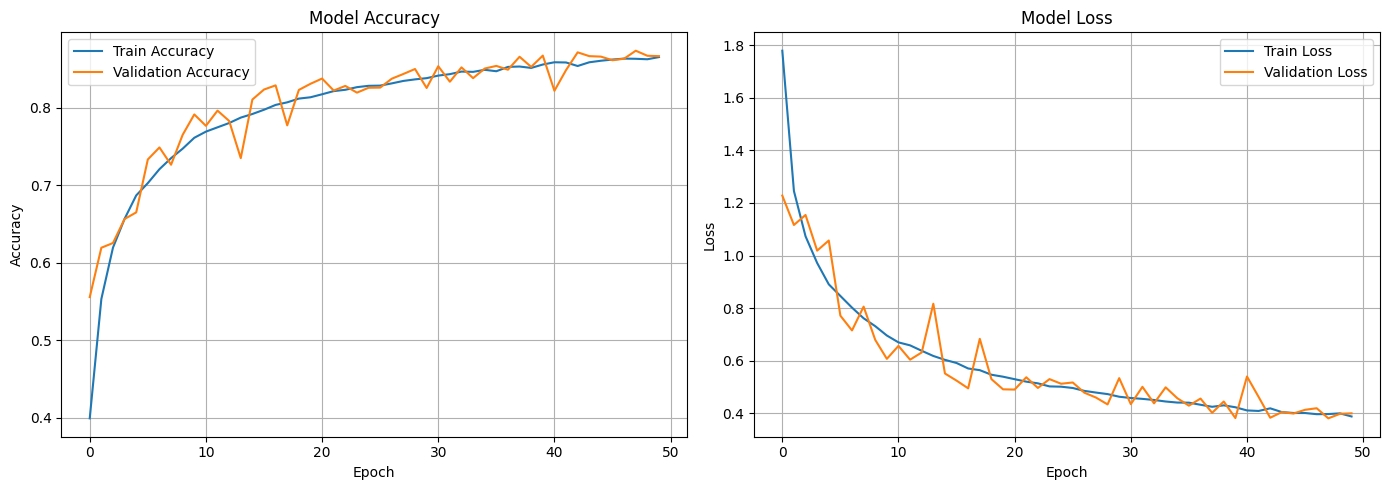

Evaluating on test set...
Test Loss: 0.4115
Test Accuracy: 0.8667
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.88      0.88      1000
  automobile       0.95      0.94      0.94      1000
        bird       0.84      0.82      0.83      1000
         cat       0.83      0.66      0.73      1000
        deer       0.86      0.85      0.86      1000
         dog       0.86      0.76      0.81      1000
        frog       0.78      0.95      0.86      1000
       horse       0.90      0.92      0.91      1000
        ship       0.90      0.95      0.92      1000
       truck       0.87      0.94      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000



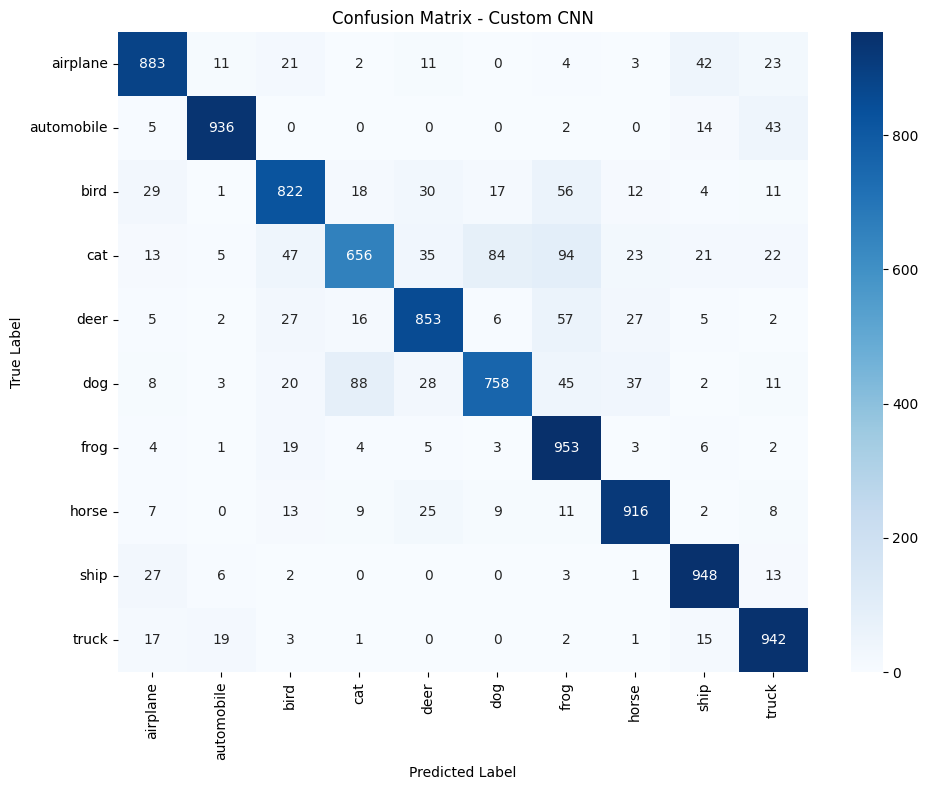

Model and results saved!


In [9]:
if __name__ == '__main__':
    # Configuration
    DATA_PATH = '/Users/nim/Downloads/cifar-10-batches-py'
    BATCH_SIZE = 64
    EPOCHS = 50
    
    print(f'TensorFlow version: {tf.__version__}')
    
    # Load data
    print('Loading CIFAR-10 dataset...')
    (X_train, y_train), (X_test, y_test), label_names = load_cifar10(DATA_PATH)
    
    # Normalize
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f'Training data shape: {X_train.shape}')
    print(f'Validation data shape: {X_val.shape}')
    print(f'Test data shape: {X_test.shape}')
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
    )
    datagen.fit(X_train)
    
    # Build model
    print('Building CNN model...')
    model = build_cnn_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        '../data/best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # Train
    print('Training model...')
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate
    print('Evaluating on test set...')
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classification report
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred_classes, target_names=label_names))
    
    # Confusion matrix
    plot_confusion_matrix(y_test, y_pred_classes, label_names)
    
    # Save model and results
    model.save('../data/custom_cnn_final.h5')
    
    results = {
        'model_name': 'Custom CNN',
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'history': history.history
    }
    
    with open('../data/custom_cnn_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    print('Model and results saved!')